In [1]:
import qiskit_algorithms.utils as utils
import qiskit_algorithms.time_evolvers.variational.variational_principles.imaginary_mc_lachlan_principle as mc_lachlan

In [2]:
mc_lachlan.idiot_function() # This is a test function to see if the homemade code is imported correctly

Idiot function


In [3]:
from qiskit_algorithms import VarQITE, TimeEvolutionProblem
from qiskit.primitives import Estimator
from qiskit_algorithms.gradients import LinCombEstimatorGradient, LinCombQGT
from qiskit_algorithms.time_evolvers.variational.variational_principles import ImaginaryMcLachlanPrinciple
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
from qiskit_nature.second_q.circuit.library import UCCSD
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.second_q.mappers import ParityMapper

In [4]:
# Hamiltonian
data = np.loadtxt('qubit_hamil_h2.txt', dtype=str)
paulistrings = data[:,0] 
coefficients = (data[:,1])
coefficients = [complex(coeff) for coeff in coefficients]
paulis = list(zip(paulistrings, coefficients))
#print(paulis)
qubit_op = SparsePauliOp.from_list(paulis)

print(f"Number of qubits: {qubit_op.num_qubits}")
#print(qubit_op)

Number of qubits: 4


In [5]:
# Ansatz
nreps = 1

#initial_point = hf_params_h2o_jw(nreps=nreps, perturb=0.00)
#print(initial_point)

ansatz = EfficientSU2(qubit_op.num_qubits, reps=nreps)

init_param_values = {}
for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]] = np.pi / 2
#print(init_param_values)

# UCCSD instead
#ansatz = UCCSD(num_spatial_orbitals=8, num_particles=[2,2], qubit_mapper=ParityMapper())
#hf_initial_point = HFInitialPoint()
#hf_initial_point.ansatz = ansatz
#init_param_values = hf_initial_point.to_numpy_array()
#print(init_param_values)

#ansatz.decompose().draw("mpl", style="iqx")

In [6]:
# Estimator
seed = 170
estimator = Estimator(options={'seed': seed})

In [30]:
###############
### VarQITE ###
###############

# The 2 main tunable parameters
total_time=40
num_timesteps = 20

var_principle = ImaginaryMcLachlanPrinciple()
time_evo = TimeEvolutionProblem(qubit_op, 
                                time=total_time, 
                                aux_operators=[qubit_op])
qite = VarQITE(ansatz, init_param_values, 
               variational_principle = var_principle,
               estimator=estimator, 
               num_timesteps=num_timesteps)
result = qite.evolve(time_evo)

In [28]:
data = np.loadtxt("energy_trace.dat")
avqite_times = data[:,0]
avqite_energies = data[:,2]


Final electronic energy: -1.91162501 Ha
Compare with Qutip ED: -4.3860854160 Ha
Compare with TC-AVQITE for UCCSD: -4.3860791082 Ha


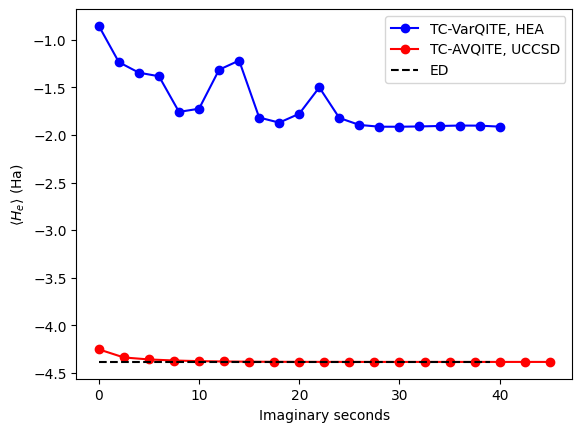

In [57]:
fig, ax = plt.subplots(1)
DELTA_BIG = 50

# Readin from file
#with open('h_exp_val.txt', 'r') as f:
#    h_exp_val = [float(num) for line in f for num in line.strip('[] \n').split()]
#with open('times.txt', 'r') as g:
#    times = [float(num) for line in g for num in line.strip('[] \n').split()]

h_exp_val = np.array([ele[0][0].real for ele in result.observables])
times = result.times

ax.plot(times, h_exp_val, '-bo', label= "TC-VarQITE, HEA") #+ extracted_transformer_energy+ nuclear_repulsion_energy
ax.plot(avqite_times[::DELTA_BIG], avqite_energies[::DELTA_BIG], '-ro', label= "TC-AVQITE, UCCSD")
ax.plot([-4.3860854160]*int(times[-1]), '--k', label= "ED")
#ax.axhline(np_result.total_energies, ls='--', 
#           c='k', alpha=0.7, label='Groundstate')
#ax.axhline(np_result.hartree_fock_energy, ls='--', 
#           c='r', alpha=0.7, label="Hartree-Fock")

#pylab.plot(times, exact_h_exp_val , label= "Exact",  linestyle='--')
ax.set_xlabel("Imaginary seconds")
ax.set_ylabel(r"$\langle H_e \rangle$ (Ha)")
ax.legend(loc="upper right");
print(f"Final electronic energy: {h_exp_val[-1]} Ha")
print(f"Compare with Qutip ED: -4.3860854160 Ha")
print(f"Compare with TC-AVQITE for UCCSD: -4.3860791082 Ha")